# Main Project 2 - U-Net을 이용한 이미지 세그멘테이션

In [1]:
import os
import random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, utils, Input, Model

import warnings
warnings.filterwarnings(action='ignore')

### (1) 실습환경 준비

In [5]:
%pip install datasets
%pip install huggingface_hub

In [4]:
import datasets
from datasets import load_dataset

train_dataset, val_dataset = load_dataset("nateraw/pascal-voc-2012", split=['train', 'val'])
dataset = pd.DataFrame(train_dataset)
dataset

,image,mask
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...
1459,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1460,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1461,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1462,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...


### (2) 데이터 전처리

- 데이터 크기 조절

In [5]:
from PIL import Image

dataset['reimage'] = None
dataset['remask'] = None

# (512, 512)로 크기 조절
for i in range(len(dataset)):
    dataset['reimage'][i] = np.array(dataset['image'][i].resize((512, 512)))
    dataset['remask'][i] = np.array(dataset['mask'][i].resize((512, 512)))

# 결측치 확인
dataset.isnull().sum()

image      0
mask       0
reimage    0
remask     0
dtype: int64

In [6]:
# data check
print(np.shape(dataset['reimage'][0]))
print(np.shape(dataset['remask'][0]))

(512, 512, 3)
(512, 512, 3)


- label image 생성

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [8]:
# colormap 만들기
def make_colormap(num=256):
    colormap = np.zeros((num, 3), dtype=int)
    ind = np.arange(num, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [9]:
cmap = list(make_colormap(21))
print(cmap)
print(len(cmap))

[array([0, 0, 0]), array([128,   0,   0]), array([  0, 128,   0]), array([128, 128,   0]), array([  0,   0, 128]), array([128,   0, 128]), array([  0, 128, 128]), array([128, 128, 128]), array([64,  0,  0]), array([192,   0,   0]), array([ 64, 128,   0]), array([192, 128,   0]), array([ 64,   0, 128]), array([192,   0, 128]), array([ 64, 128, 128]), array([192, 128, 128]), array([ 0, 64,  0]), array([128,  64,   0]), array([  0, 192,   0]), array([128, 192,   0]), array([  0,  64, 128])]
21


In [10]:
dataset['label'] = None

with tf.device('/GPU:0'):
    for i in range(len(dataset)):
        label = np.zeros((512, 512), dtype='uint8')

        for index, val_col in enumerate(cmap):
            label[np.where(np.all(dataset['remask'][i] == val_col, axis=-1))] = index

        dataset['label'][i] = label

        if i % 100 == 0:
            print(f"mask {i} done!")

mask 0 done!
mask 100 done!
mask 200 done!
mask 300 done!
mask 400 done!
mask 500 done!
mask 600 done!
mask 700 done!
mask 800 done!
mask 900 done!
mask 1000 done!
mask 1100 done!
mask 1200 done!
mask 1300 done!
mask 1400 done!


In [11]:
color_list = []
for i in range(len(dataset['label'])):
    color_list.append(dataset['label'][i].flatten())
set(np.array(color_list).flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [12]:
dataset['label'][1][250,169]

20

In [13]:
# train, test set split
train_size = math.floor(len(dataset) * 0.7)
val_size = math.floor(len(dataset) * 0.9)

image_dataset = np.array(list(dataset['reimage']))
label_dataset = np.array(list(dataset['label']))[:, :, :, np.newaxis]

train_image = image_dataset[:train_size]
train_label = label_dataset[:train_size]

val_image = image_dataset[train_size:val_size]
val_label = label_dataset[train_size:val_size]

test_image = image_dataset[val_size:]
test_label = label_dataset[val_size:]

In [14]:
print(np.shape(train_image))
print(np.shape(train_label))

(1024, 512, 512, 3)
(1024, 512, 512, 1)


### (3) U-Net 구현

- Convolution block

In [15]:
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

- Encoder block

In [16]:
def encode_block(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    e = layers.MaxPooling2D((2, 2))(x)

    return x, e

- Decoder block

In [17]:
def decode_block(inputs, skip, n_filters):
    d = layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([d, skip])
    x = conv_block(x, n_filters)

    return x

- U-Net

In [18]:
def UNET(n_classes):
    inputs = Input(shape=(512, 512, 3))

    e1, x = encode_block(inputs, 64)
    e2, x = encode_block(x, 128)
    e3, x = encode_block(x, 256)
    e4, x = encode_block(x, 512)

    x = conv_block(x, 1024)

    x = decode_block(x, e4, 512)
    x = decode_block(x, e3, 256)
    x = decode_block(x, e2, 128)
    x = decode_block(x, e1, 64)

    if n_classes == 1:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x)
    else:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)

    return Model(inputs, x, name='U-Net')

In [19]:
with tf.device('/GPU:0'):
    model = UNET(21)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

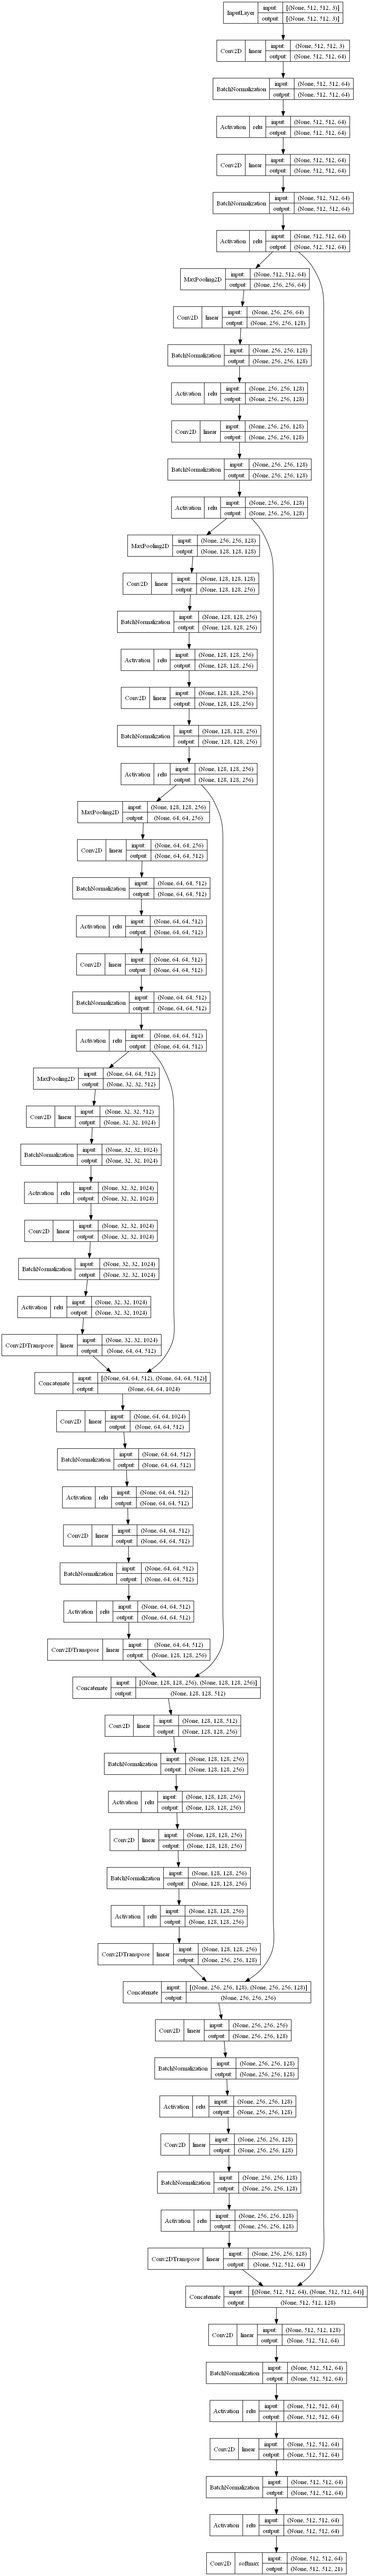

In [20]:
utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

### (4) 모델 학습

In [22]:
BATCH_SIZE = 8
EPOCHS = 20

In [23]:
print(train_image.dtype)
print(train_label.dtype)

uint8
uint8


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
tensorboard = keras.callbacks.Tensorboard(log_dir="./drive/MyDrive/Colab\ Notebooks/tensorboard/")

AttributeError: ignored

In [24]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath="./checkpoint.keras", monitor="val_loss", save_best_only=True)
]

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_image,
        train_label,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks_list,
        validation_data=(val_image, val_label)
    )

Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 1.5627 - sparse_categorical_accuracy: 0.7364

128/128 [==============================] - 432s 3s/step - loss: 1.5627 - sparse_categorical_accuracy: 0.7364 - val_loss: 38.1232 - val_sparse_categorical_accuracy: 0.7381
Epoch 2/20
128/128 [==============================] - ETA: 0s - loss: 1.1353 - sparse_categorical_accuracy: 0.7733

128/128 [==============================] - 361s 3s/step - loss: 1.1353 - sparse_categorical_accuracy: 0.7733 - val_loss: 3.4956 - val_sparse_categorical_accuracy: 0.6296
Epoch 3/20
128/128 [==============================] - ETA: 0s - loss: 1.1066 - sparse_categorical_accuracy: 0.7732

128/128 [==============================] - 377s 3s/step - loss: 1.1066 - sparse_categorical_accuracy: 0.7732 - val_loss: 1.4097 - val_sparse_categorical_accuracy: 0.7334
Epoch 4/20
128/128 [==============================] - ETA: 0s - loss: 1.0911 - sparse_categorical_accuracy: 0.7733

128/128 [==============================] - 401s 3s/step - loss: 1.0911 - sparse_categorical_accuracy: 0.7733 - val_loss: 1.3259 - val_sparse_categorical_accuracy: 0.7360
Epoch 5/20
128/128 [==============================] - ETA: 0s - loss: 1.0864 - sparse_categorical_accuracy: 0.7738

128/128 [==============================] - 296s 2s/step - loss: 1.0864 - sparse_categorical_accuracy: 0.7738 - val_loss: 1.4662 - val_sparse_categorical_accuracy: 0.7373
Epoch 6/20
128/128 [==============================] - ETA: 0s - loss: 1.0809 - sparse_categorical_accuracy: 0.7736

128/128 [==============================] - 280s 2s/step - loss: 1.0809 - sparse_categorical_accuracy: 0.7736 - val_loss: 1.3503 - val_sparse_categorical_accuracy: 0.7306
Epoch 7/20
128/128 [==============================] - ETA: 0s - loss: 1.0661 - sparse_categorical_accuracy: 0.7734

128/128 [==============================] - 280s 2s/step - loss: 1.0661 - sparse_categorical_accuracy: 0.7734 - val_loss: 1.3426 - val_sparse_categorical_accuracy: 0.7370
Epoch 8/20
128/128 [==============================] - ETA: 0s - loss: 1.0683 - sparse_categorical_accuracy: 0.7739

128/128 [==============================] - 422s 3s/step - loss: 1.0683 - sparse_categorical_accuracy: 0.7739 - val_loss: 1.3246 - val_sparse_categorical_accuracy: 0.7375
Epoch 9/20
128/128 [==============================] - ETA: 0s - loss: 1.0645 - sparse_categorical_accuracy: 0.7739

128/128 [==============================] - 281s 2s/step - loss: 1.0645 - sparse_categorical_accuracy: 0.7739 - val_loss: 1.4559 - val_sparse_categorical_accuracy: 0.7237
Epoch 10/20
128/128 [==============================] - ETA: 0s - loss: 1.0530 - sparse_categorical_accuracy: 0.7740

128/128 [==============================] - 434s 3s/step - loss: 1.0530 - sparse_categorical_accuracy: 0.7740 - val_loss: 1.2600 - val_sparse_categorical_accuracy: 0.7339
Epoch 11/20
128/128 [==============================] - ETA: 0s - loss: 1.0467 - sparse_categorical_accuracy: 0.7741

128/128 [==============================] - 455s 4s/step - loss: 1.0467 - sparse_categorical_accuracy: 0.7741 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.7318
Epoch 12/20
128/128 [==============================] - ETA: 0s - loss: 1.0447 - sparse_categorical_accuracy: 0.7739

128/128 [==============================] - 296s 2s/step - loss: 1.0447 - sparse_categorical_accuracy: 0.7739 - val_loss: 1.4270 - val_sparse_categorical_accuracy: 0.7371
Epoch 13/20
128/128 [==============================] - ETA: 0s - loss: 1.0390 - sparse_categorical_accuracy: 0.7745

128/128 [==============================] - 296s 2s/step - loss: 1.0390 - sparse_categorical_accuracy: 0.7745 - val_loss: 1.3099 - val_sparse_categorical_accuracy: 0.7376
Epoch 14/20
128/128 [==============================] - ETA: 0s - loss: 1.0402 - sparse_categorical_accuracy: 0.7743

128/128 [==============================] - 494s 4s/step - loss: 1.0402 - sparse_categorical_accuracy: 0.7743 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.7341
Epoch 15/20
128/128 [==============================] - ETA: 0s - loss: 1.0341 - sparse_categorical_accuracy: 0.7746

128/128 [==============================] - 435s 3s/step - loss: 1.0341 - sparse_categorical_accuracy: 0.7746 - val_loss: 1.2096 - val_sparse_categorical_accuracy: 0.7320
Epoch 16/20
128/128 [==============================] - ETA: 0s - loss: 1.0218 - sparse_categorical_accuracy: 0.7743

128/128 [==============================] - 297s 2s/step - loss: 1.0218 - sparse_categorical_accuracy: 0.7743 - val_loss: 1.4036 - val_sparse_categorical_accuracy: 0.7373
Epoch 17/20
128/128 [==============================] - ETA: 0s - loss: 1.0197 - sparse_categorical_accuracy: 0.7752

128/128 [==============================] - 297s 2s/step - loss: 1.0197 - sparse_categorical_accuracy: 0.7752 - val_loss: 1.2474 - val_sparse_categorical_accuracy: 0.7386
Epoch 18/20
128/128 [==============================] - ETA: 0s - loss: 1.0252 - sparse_categorical_accuracy: 0.7742

128/128 [==============================] - 297s 2s/step - loss: 1.0252 - sparse_categorical_accuracy: 0.7742 - val_loss: 1.2342 - val_sparse_categorical_accuracy: 0.7384
Epoch 19/20
128/128 [==============================] - ETA: 0s - loss: 1.0082 - sparse_categorical_accuracy: 0.7750

128/128 [==============================] - 309s 2s/step - loss: 1.0082 - sparse_categorical_accuracy: 0.7750 - val_loss: 1.2173 - val_sparse_categorical_accuracy: 0.7312
Epoch 20/20
128/128 [==============================] - ETA: 0s - loss: 1.0046 - sparse_categorical_accuracy: 0.7745

128/128 [==============================] - 405s 3s/step - loss: 1.0046 - sparse_categorical_accuracy: 0.7745 - val_loss: 1.1939 - val_sparse_categorical_accuracy: 0.7382


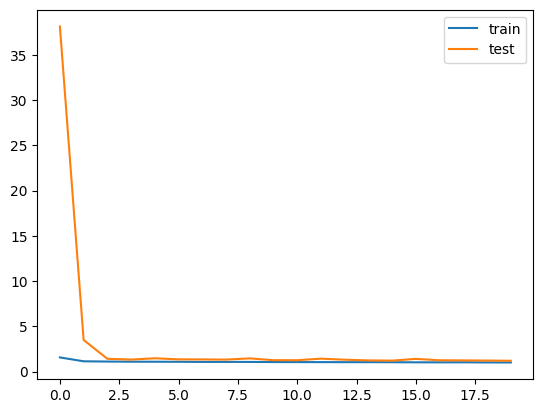

In [27]:
# 데이터 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
loss, accuracy = model.evaluate(test_image)
print(f'Loss: {loss},\nAccuracy: {accuracy}')

5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00
Loss: 0.0,
Accuracy: 0.0


In [2]:
from keras.models import load_model

new_model = load_model('./checkpoint.keras')

In [21]:
prediction = new_model.predict(test_image)

5/5 [==============================] - 177s 30s/step


In [22]:
np.shape(prediction)

(147, 512, 512, 21)

In [31]:
new_prediction = np.argmax(prediction, axis=3)[:, :, :, np.newaxis]
np.shape(new_prediction)

(147, 512, 512, 1)

In [38]:
new_pred_list = []

for i in new_prediction:
    new_pred_list.append(set(i.flatten()))

new_pred_list

[{0, 15},
 {0, 15},
 {0, 15},
 {0},
 {0, 15},
 {0, 15},
 {0, 15},
 {0},
 {0, 15},
 {0, 15},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0, 16},
 {0, 6, 15, 19},
 {0},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0, 3, 15, 19},
 {0},
 {0, 15},
 {0},
 {0, 15},
 {0},
 {0},
 {0, 15},
 {0},
 {0},
 {0},
 {0},
 {0, 15},
 {0, 15},
 {0, 15},


In [39]:
new_test_list = []

for i in test_label:
    new_test_list.append(set(i.flatten()))

new_test_list

[{0, 15},
 {0, 13, 15},
 {0, 14, 15},
 {0, 17},
 {0, 15},
 {0, 15, 18},
 {0, 14},
 {0, 14},
 {0, 5, 15},
 {0, 8},
 {0, 15},
 {0, 13},
 {0, 1},
 {0, 1},
 {0, 3, 15, 17},
 {0, 13},
 {0, 1, 15},
 {0, 13},
 {0, 19},
 {0, 5},
 {0, 15, 16},
 {0, 19},
 {0, 8},
 {0, 13},
 {0, 15, 19},
 {0, 8},
 {0, 7},
 {0, 6},
 {0, 9, 15, 18},
 {0, 1},
 {0, 8, 9},
 {0, 3, 9, 11},
 {0, 19},
 {0, 9, 16, 18},
 {0, 12, 18},
 {0, 3},
 {0, 3},
 {0, 6, 7},
 {0, 11, 15},
 {0, 15},
 {0, 9, 18},
 {0, 6},
 {0, 9, 11, 16, 18},
 {0, 3},
 {0, 3},
 {0, 15},
 {0, 6},
 {0, 6, 15},
 {0, 6, 15},
 {0, 7},
 {0, 5, 9, 11, 15},
 {0, 9, 15},
 {0, 16},
 {0, 2, 7, 15},
 {0, 3},
 {0, 10},
 {0, 7},
 {0, 4, 15},
 {0, 15, 20},
 {0, 1},
 {0, 8},
 {0, 3},
 {0, 14, 15},
 {0, 15},
 {0, 17},
 {0, 12},
 {0, 3},
 {0, 1},
 {0, 15, 18},
 {0, 3},
 {0, 15, 19},
 {0, 15, 18},
 {0, 3},
 {0, 15, 16, 20},
 {0, 3},
 {0, 3},
 {0, 9},
 {0, 18},
 {0, 4},
 {0, 17},
 {0, 4},
 {0, 14},
 {0, 2, 5, 7, 15},
 {0, 1},
 {0, 17},
 {0, 10},
 {0, 2, 5, 7, 15},
 {0, 15}

In [40]:
loss, accuracy = new_model.evaluate(test_image)
print(f'Loss: {loss},\nAccuracy: {accuracy}')

5/5 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00
Loss: 0.0,
Accuracy: 0.0
